## Selecting Optimal Number of Components for Mobility Data Analysis using TensorLy CMTF-ALS on Safegraph Mobily Data

In [1]:
# Import general packages
import numpy as np
import scipy
import pandas as pd

In [2]:
# Import CMTF specific packages
import tensorly as tl
import xarray
import tlviz

In [3]:
# Packages for spatial, temporal data analysis

#import geopandas as gpd
#import fiona

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

from datetime import datetime
from datetime import date

#from shapely.geometry import box
#from mpl_toolkits.axes_grid1 import make_axes_locatable

#### Load Data

In [5]:
# Loading tensor, matrix
tensor_imported = np.loadtxt('mobility_data_final_500_tensor.csv', delimiter=",")
mobility_matrix = np.loadtxt('mobility_data_final_500_matrix.csv', delimiter=",")

# Folding back into tensor
mobility_tensor = tl.fold(tensor_imported, 0, (500, 12, 53))

#### Fitting many CMTF decomposition models
Fitting CMTF models is a non-convex optimization problem, so it is better to fit multiple models using same number of components using different random initializations and one singular value decomposition (SVD)

In [6]:
# Import TensorLy CMTF-ALS
from tensorly.decomposition._cmtf_als import coupled_matrix_tensor_3d_factorization as cmtf_als
tl.set_backend('numpy')

In [7]:
# Fitting num_inits=5 initializations and one singular value decomposition initialization (more consistent)

def fit_many_cmtf(tensor, matrix, rank, num_inits=5):
    cmtf_models = [cmtf_als(tensor, matrix, rank, init="random") for i in range(num_inits)]
    cmtf_models.append(cmtf_als(tensor, matrix, rank, init="svd"))
    
    return cmtf_models

In [43]:
# Perform and store initializations for different ranks

rank_list = [1, 2, 3, 4, 5]
cmtf_models = {}

for rank in rank_list:
    print(f"{rank} components")
    cmtf_models[rank] = fit_many_cmtf(mobility_tensor, mobility_matrix, rank, num_inits=5)

1 components
2 components
3 components
4 components
5 components


### Diagnostics for CMTF
Based on TLViz: http://tensorly.org/viz/stable/auto_examples/plot_selecting_aminoacids_components.html#sphx-glr-auto-examples-plot-selecting-aminoacids-components-py

#### Computing Sum Squared Error (relative SSE)

In [44]:
# Calculating relative SSE for each decomposition

from tlviz.model_evaluation import relative_sse

tensor_sse_errors = {}

for rank in rank_list:
    tensor_sse_errors[rank] = [(relative_sse(cmtf_models[rank][i][0], mobility_tensor)) for i in range(6)]

In [45]:
tensor_selected_models = {}

for rank in rank_list:
    tensor_selected_models[rank] = cmtf_models[rank][tensor_sse_errors[rank].index(np.amin(tensor_sse_errors[rank]))][0]

#### Examining Model Uniqueness
Use Factor Match Score (FMS) to compare each initialization with the lowest SSE initialization. FMS value of 1 means components are equivalent.

In [46]:
from tlviz.multimodel_evaluation import similarity_evaluation

fms_tensor_selected = {}

for rank in rank_list:
    fms_tensor_selected[rank] = similarity_evaluation(tensor_selected_models[rank], [cmtf_models[rank][i][0] for i in range(6)])

### Save diagnostics

In [39]:
import json
  
with open('diagnostics_final_500_tensor_sse', 'w') as sse_file:
     sse_file.write(json.dumps(tensor_sse_errors))

#with open('diagnostics_final_500_tensor_selected_models', 'w') as models_file:
     #models_file.write(json.dumps(tensor_selected_models))

with open('diagnostics_final_500_fms_tensor', 'w') as fms_file:
     fms_file.write(json.dumps(fms_tensor_selected))

#### Plot Uniqueness Information

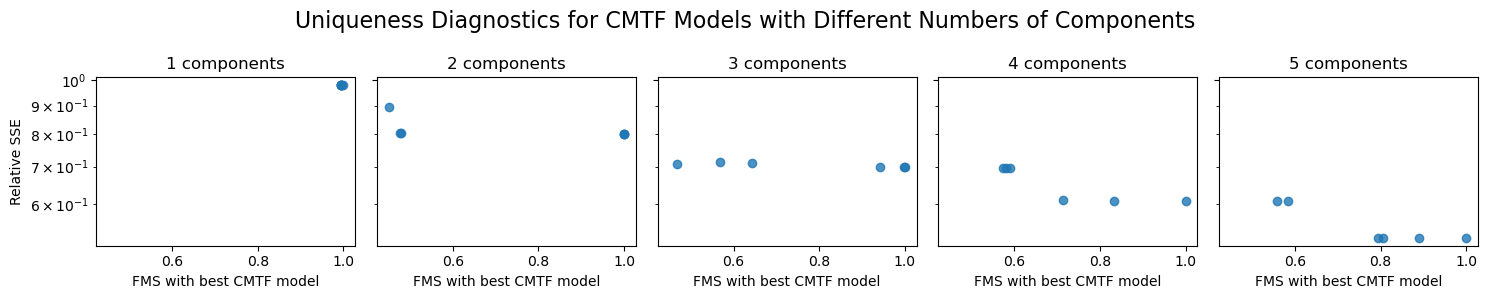

In [47]:
fig, axes = plt.subplots(1, len(rank_list), figsize=(15, 3), tight_layout=True, sharex=True, sharey=True)

for i, rank in enumerate(tensor_sse_errors):
    axes[i].scatter(fms_tensor_selected[rank], tensor_sse_errors[rank], alpha=0.8)
    axes[i].set_title(f"{rank} components")
    axes[i].set_xlabel("FMS with best CMTF model")
    axes[i].set_yscale("log")

axes[0].set_ylabel("Relative SSE")
fig.suptitle("Uniqueness Diagnostics for CMTF Models with Different Numbers of Components", fontsize=16)
plt.show()

#fig.savefig('final_500_uniqueness_plot_mobility_analysis.png', dpi=1200) # Saved

#### Scree Plot of Fit and Core Consistency

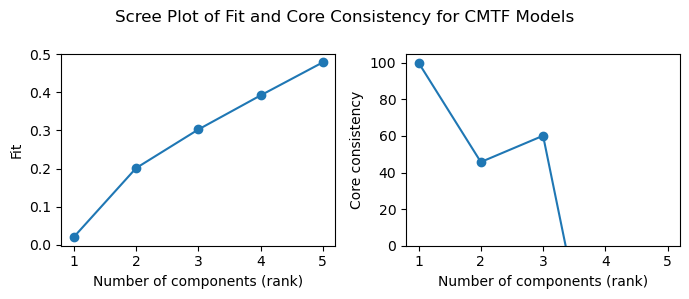

In [48]:
from tlviz.visualisation import scree_plot

fig, axes = plt.subplots(1, 2, figsize=(7, 3), tight_layout=True, sharex=True)

plt.xticks(rank_list)
axes[0].set_xlabel("Number of components (rank)")
axes[1].set_xlabel("Number of components (rank)")

scree_plot(tensor_selected_models, mobility_tensor, metric="Fit", ax=axes[0])
scree_plot(tensor_selected_models, mobility_tensor, metric="Core consistency", ax=axes[1])

axes[1].set_ylim(0, 105)
fig.suptitle("Scree Plot of Fit and Core Consistency for CMTF Models")
plt.show()
#fig.savefig('final_500_scree_plot_mobility_analysis.png', dpi=1200) # Saved

#### Core Element Plot

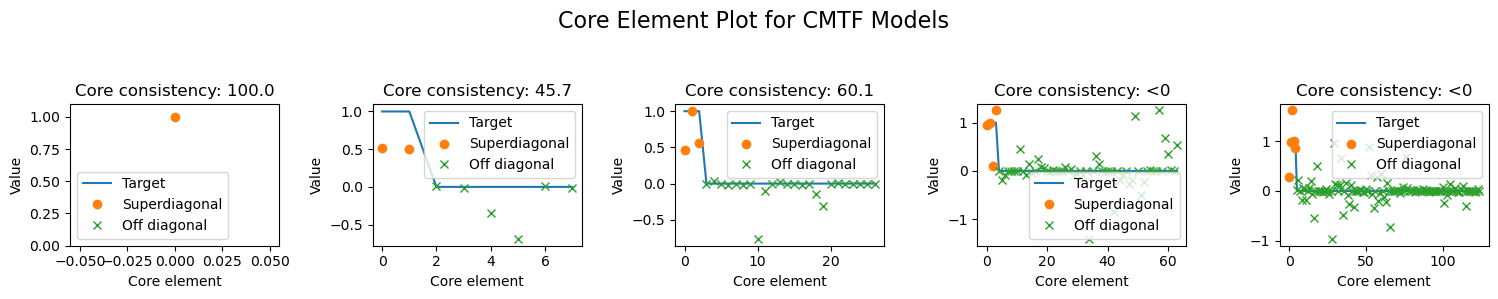

In [49]:
fig, axes = plt.subplots(1, len(rank_list), figsize=(15, 3), tight_layout=True, sharex=False, sharey=False)

for i, (rank, model) in enumerate(tensor_selected_models.items()):
    axes[i].set_title(f"{rank} components")
    tlviz.visualisation.core_element_plot(model, mobility_tensor, ax=axes[i])

fig.suptitle("Core Element Plot for CMTF Models\n", fontsize=16)
plt.show()
#fig.savefig('final_500_core_element_plot_mobility_analysis.png', dpi=1200) # Saved